# Model comparisons

Plan to test
- Random forest
- CNN
- Kernel SVM ?
- Gradient Boosting ?

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("G:/My Drive/Erdos/Fall2022_Juniper/train.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-null  int64
 12  Wild

No missing data

In [4]:
data.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,...,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,...,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,11340.25000,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,15120.00000,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


## Checking correlation

In [5]:
corr = data.corr()

<AxesSubplot:>

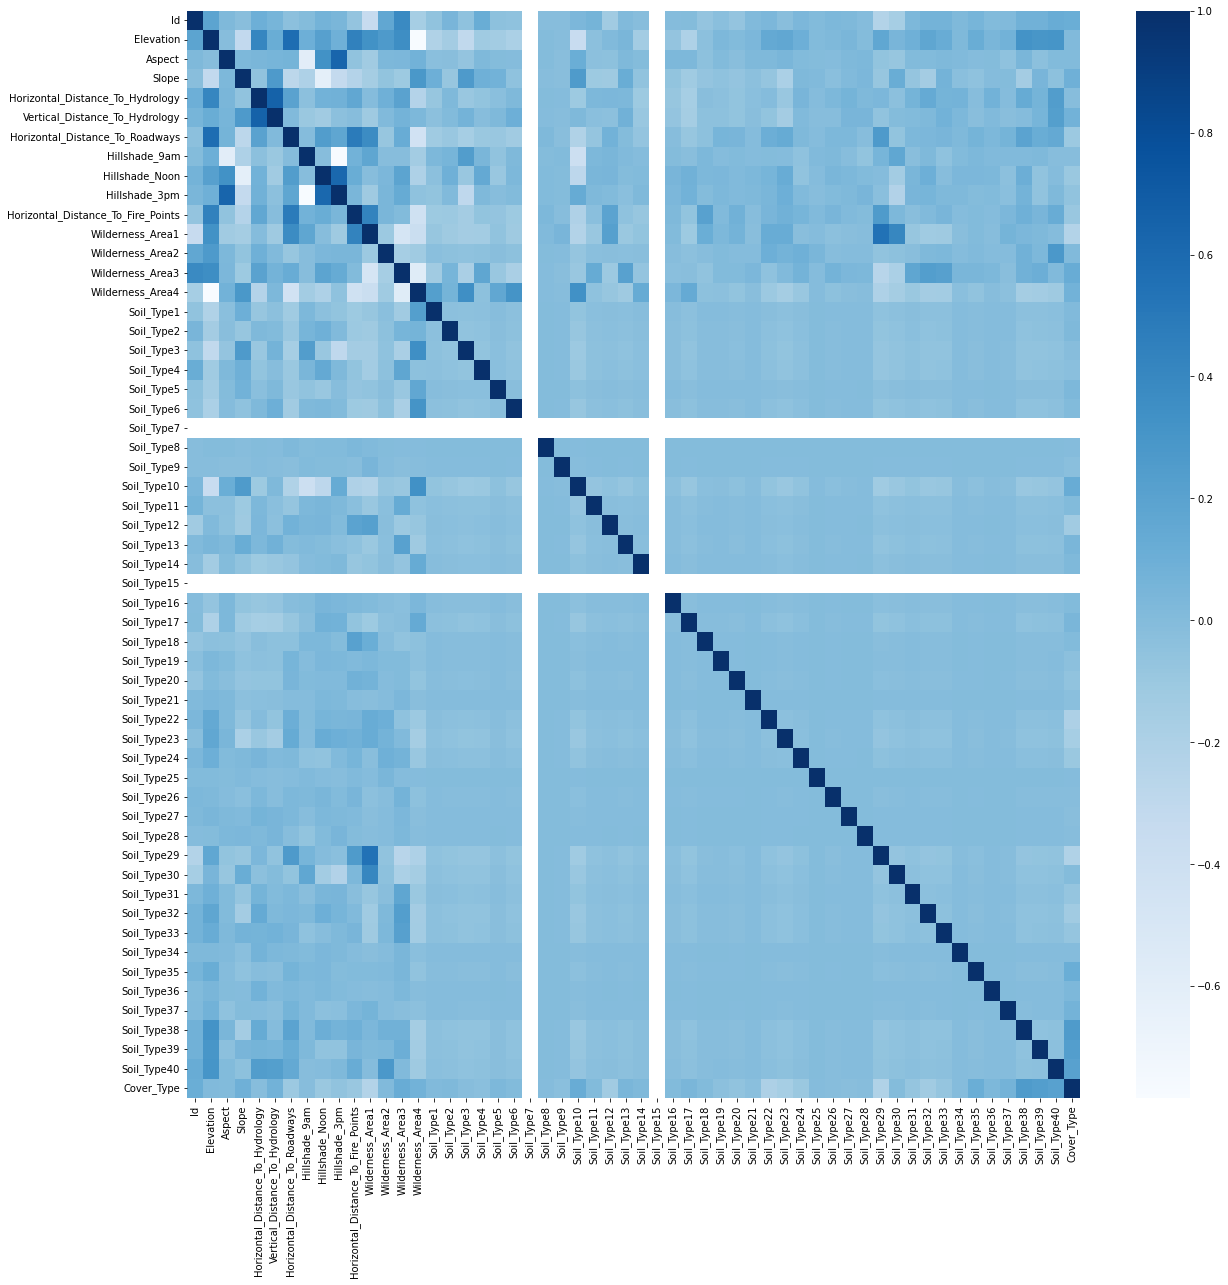

In [6]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr,cmap='Blues')

Soil_type7 and Soil_type15 don't have any correlations with Cover_Type, so they can be removed for the predition.

In [7]:
corr_high = corr.unstack()
corr_high = corr_high[abs(corr_high) >= 0.6]
corr_high = corr_high[abs(corr_high) < 1]
corr_high.sort_values(key=abs)

Slope                             Hillshade_Noon                     -0.612613
Hillshade_Noon                    Slope                              -0.612613
                                  Hillshade_3pm                       0.614526
Hillshade_3pm                     Hillshade_Noon                      0.614526
Aspect                            Hillshade_3pm                       0.635022
Hillshade_3pm                     Aspect                              0.635022
Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology      0.652142
Vertical_Distance_To_Hydrology    Horizontal_Distance_To_Hydrology    0.652142
Hillshade_9am                     Hillshade_3pm                      -0.779965
Hillshade_3pm                     Hillshade_9am                      -0.779965
Elevation                         Wilderness_Area4                   -0.783651
Wilderness_Area4                  Elevation                          -0.783651
dtype: float64

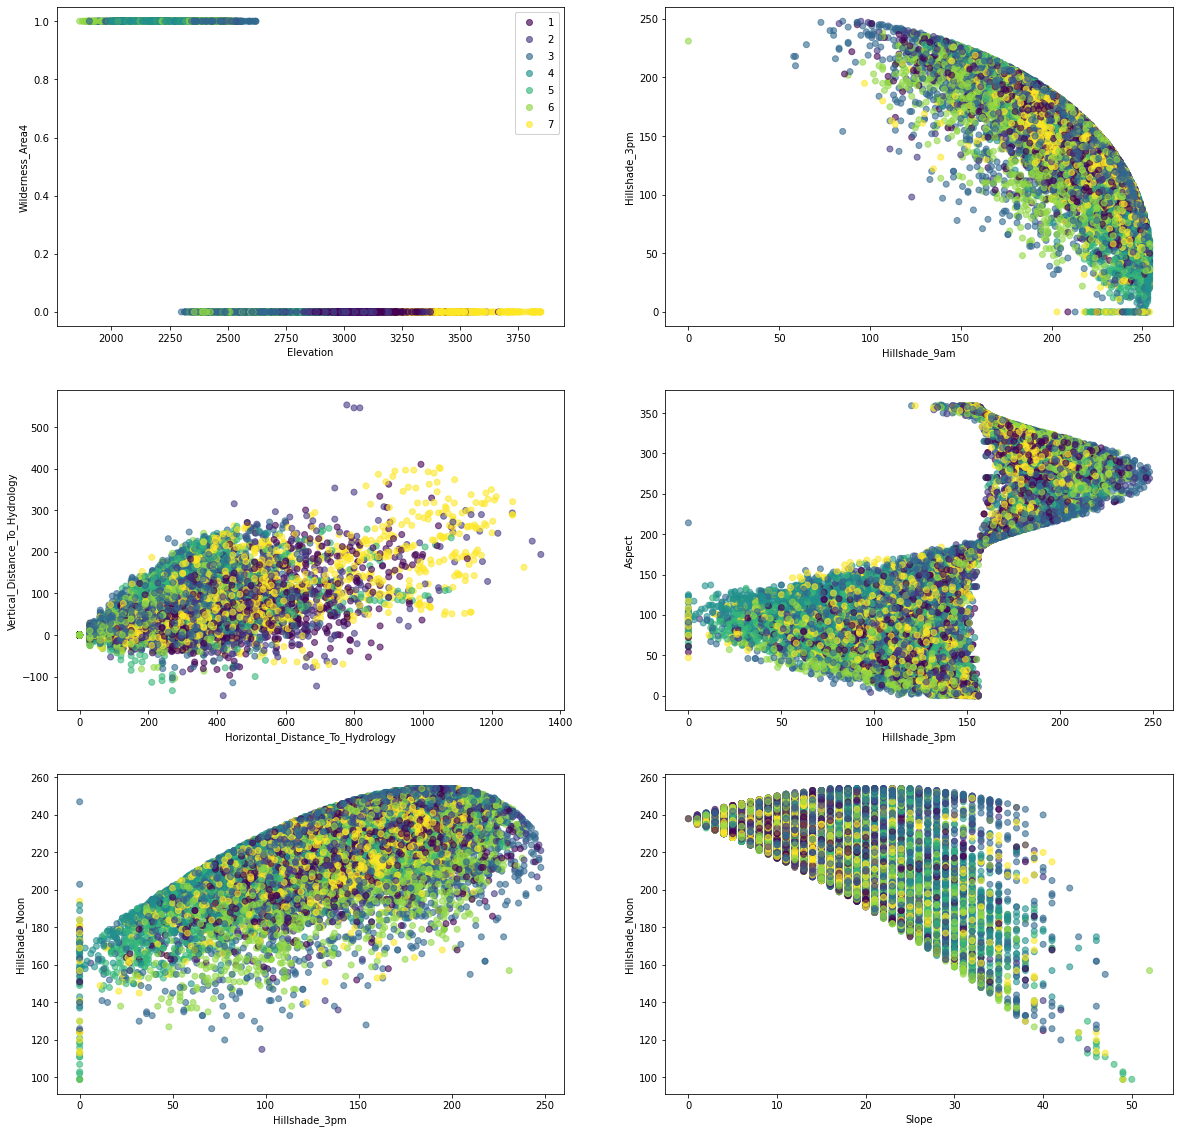

In [8]:
figure, axis = plt.subplots(3,2,figsize=(20,20))

sc1 = axis[0, 0].scatter(data.Elevation, data.Wilderness_Area4, c = data.Cover_Type, alpha = 0.6)
axis[0, 0].set(xlabel='Elevation', ylabel='Wilderness_Area4')
legend1 = axis[0, 0].legend(*sc1.legend_elements())
axis[0, 0].add_artist(legend1)

axis[0, 1].scatter(data.Hillshade_9am, data.Hillshade_3pm,c = data.Cover_Type, alpha = 0.6)
axis[0, 1].set(xlabel='Hillshade_9am', ylabel='Hillshade_3pm')

axis[2, 1].scatter(data.Slope, data.Hillshade_Noon,c = data.Cover_Type, alpha = 0.6)
axis[2, 1].set(xlabel='Slope', ylabel='Hillshade_Noon')

axis[2, 0].scatter(data.Hillshade_3pm, data.Hillshade_Noon,c = data.Cover_Type, alpha = 0.6)
axis[2, 0].set(xlabel='Hillshade_3pm', ylabel='Hillshade_Noon')

axis[1, 1].scatter(data.Hillshade_3pm, data.Aspect,c = data.Cover_Type, alpha = 0.6)
axis[1, 1].set(xlabel='Hillshade_3pm', ylabel='Aspect')

axis[1, 0].scatter(data.Horizontal_Distance_To_Hydrology, data.Vertical_Distance_To_Hydrology,c = data.Cover_Type, alpha = 0.6)
axis[1, 0].set(xlabel = "Horizontal_Distance_To_Hydrology", ylabel = "Vertical_Distance_To_Hydrology")

plt.show()

They seem to have some relationships. How can I add them to features?

## Train test data split

In [9]:
data1 = data.copy(deep=True)
X = data1.drop(['Cover_Type', "Soil_Type7", "Soil_Type15"],axis=1)
y = data1['Cover_Type']

implement cross-validataion later-
kfold = KFold(n_splits = 5, shuffle = True, random_state = 314)

In [10]:
X_train,X_test, y_train, y_test = train_test_split(X,y,
                               shuffle = True,
                               random_state=314,
                               test_size=0.2)

In [11]:
unique, count= np.unique(y_train, return_counts=True)
print("The number of occurances of each class = %s " % dict (zip(unique, count) ), "\n" )

The number of occurances of each class = {1: 1738, 2: 1717, 3: 1741, 4: 1726, 5: 1719, 6: 1695, 7: 1760}  



C:\Users\m0eka\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

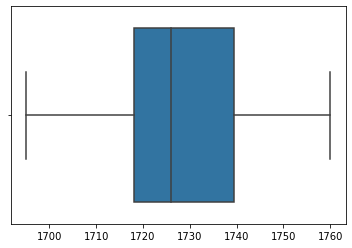

In [12]:
sns.boxplot(count)

No outliers. The number of occurances in each class are roughly similar.

## Random Forest - Base model

No need for standard scaling. Find the best accuracy scores with n_estimators of 100, 200, 300, and 400.

In [13]:
rf_accuracy = {}
for i in range(1,5):
    rf = RandomForestClassifier(n_estimators = 100*i)
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    rf_accuracy[100*i] = round(accuracy_score(y_test, y_pred),4)
print(rf_accuracy)

{100: 0.8743, 200: 0.88, 300: 0.8793, 400: 0.8767}


n_estimators of 200 has the highest accuracy among 4. So, let's use this for the later analysis.

In [14]:
rf = RandomForestClassifier(n_estimators = 200)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

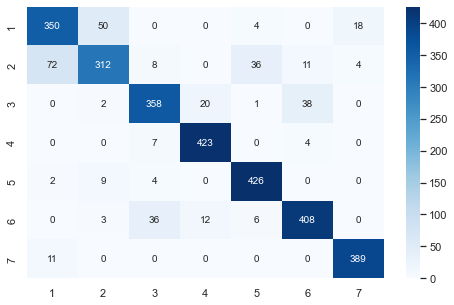

In [15]:
rf_confusion = confusion_matrix(y_test,y_pred)
rf_cm = pd.DataFrame(rf_confusion, 
                     index = [i for i in "1234567"],
                     columns = [i for i in "1234567"])
plt.figure(figsize=(8,5))
sns.set(font_scale=1)
sns.heatmap(rf_cm,annot=True,fmt='g', cmap='Blues',
           annot_kws={"size": 10})
plt.show()

In [16]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Random Forest Model')
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, 
                            target_names=['1','2','3','4','5','6','7']))

Random Forest Model

Accuracy: 0.88

Micro Precision: 0.88
Micro Recall: 0.88
Micro F1-score: 0.88

Macro Precision: 0.88
Macro Recall: 0.88
Macro F1-score: 0.88

Weighted Precision: 0.88
Weighted Recall: 0.88
Weighted F1-score: 0.88

Classification Report

              precision    recall  f1-score   support

           1       0.80      0.83      0.82       422
           2       0.83      0.70      0.76       443
           3       0.87      0.85      0.86       419
           4       0.93      0.97      0.95       434
           5       0.90      0.97      0.93       441
           6       0.89      0.88      0.88       465
           7       0.95      0.97      0.96       400

    accuracy                           0.88      3024
   macro avg       0.88      0.88      0.88      3024
weighted avg       0.88      0.88      0.88      3024



## Additional feature construction

## KNN test
First, standardize the continuous data. Does standardscaler work for different distrubutions?